## VGGNet (2014)

## VGG19

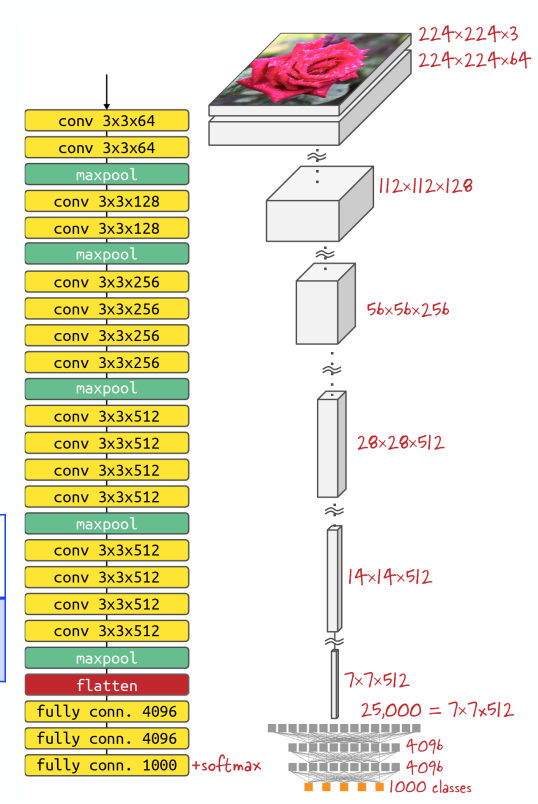

## one of drawback of VGG was that it couldn't go as deep as wanted, because it causes ***overfitting*** due to ***vanshing gradient***.

## Librairs

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data.sampler import SubsetRandomSampler

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Data

In [ ]:
def data_loader(data_dir, batch_size= 64, random_seed= 42, valid_size= 0.1, shuffle= True, test= False):
  normalize= transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010])

  transform= transforms.Compose([
      transforms.Resize((224, 244)),
      transforms.ToTensor(),
      normalize
  ])

  test_loader= None

  if test:
    test_dataset= torchvision.datasets.CIFAR10(data_dir, train= False, transform= transform, download= True)

    test_loader= torch.utils.data.DataLoader(test_dataset, batch_size= batch_size, shuffle= shuffle)

    return test_loader

  train_dataset= torchvision.datasets.CIFAR10(data_dir, train= True, transform= transform, download= True)
  val_dataset= torchvision.datasets.CIFAR10(data_dir, train= True, transform= transform, download= True)

  num_train= len(train_dataset)
  indices= list(range(num_train))
  split= int(np.floor(valid_size * num_train))

  if shuffle:
      np.random.seed(random_seed)
      np.random.shuffle(indices)

  train_idx, valid_idx = indices[split:], indices[:split]
  train_sampler= SubsetRandomSampler(train_idx)
  val_sampler= SubsetRandomSampler(valid_idx)

  train_loader= torch.utils.data.DataLoader(train_dataset, batch_size= batch_size, sampler= train_sampler)
  valid_loader= torch.utils.data.DataLoader(val_dataset, batch_size= batch_size, sampler= val_sampler)

  return train_loader, valid_loader

In [ ]:
train_loader, val_loader= data_loader(data_dir= "./data", batch_size= 64, valid_size= 0.1, shuffle= True)
test_loader= data_loader(data_dir= "./data", batch_size= 64, valid_size= 0.1, shuffle= False, test= True)

100%|██████████| 170498071/170498071 [00:03<00:00, 42863301.87it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


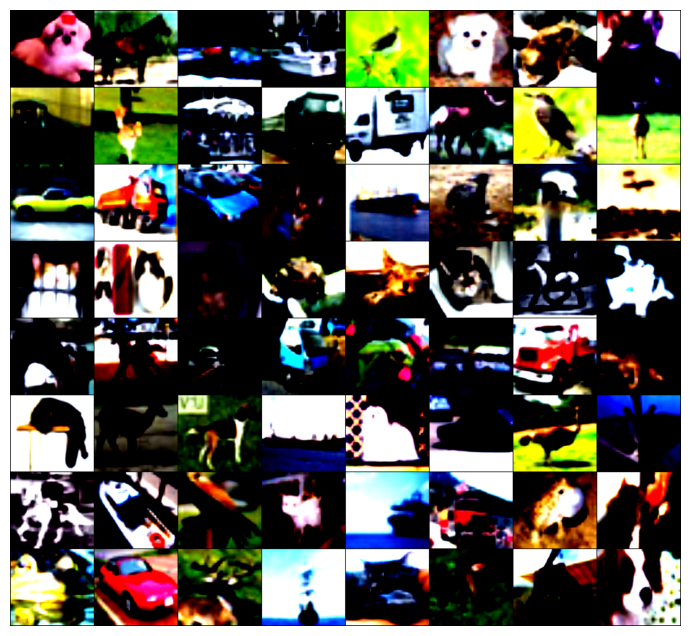

In [ ]:
for images, _ in train_loader:
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0)))
    break

## VGG16

In [ ]:
class VGG19(nn.Module):
  def __init__(self, num_classes= 10):
    super(VGG19, self).__init__()

    self.layer1= nn.Sequential(
        nn.Conv2d(3, 64, kernel_size= 3, padding= 1, stride= 1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Conv2d(64, 64, kernel_size= 3, padding= 1, stride= 1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2, stride= 2)
    )

    self.layer2= nn.Sequential(
        nn.Conv2d(64, 128, kernel_size= 3, padding= 1, stride= 1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.Conv2d(128, 128, kernel_size= 3, padding= 1, stride= 1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(2, stride= 2)
    )

    self.layer3= nn.Sequential(
        nn.Conv2d(128, 256, kernel_size= 3, padding= 1, stride= 1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size= 3, padding= 1, stride= 1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size= 3, padding= 1, stride= 1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size= 3, padding= 1, stride= 1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(2, stride= 2)
    )

    self.layer4= nn.Sequential(
        nn.Conv2d(256, 512, kernel_size= 3, padding= 1, stride= 1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.Conv2d(512, 512, kernel_size= 3, padding= 1, stride= 1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.Conv2d(512, 512, kernel_size= 3, padding= 1, stride= 1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.Conv2d(512, 512, kernel_size= 3, padding= 1, stride= 1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.MaxPool2d(2, stride= 2)
    )

    self.layer5= nn.Sequential(
        nn.Conv2d(512, 512, kernel_size= 3, padding= 1, stride= 1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.Conv2d(512, 512, kernel_size= 3, padding= 1, stride= 1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.Conv2d(512, 512, kernel_size= 3, padding= 1, stride= 1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.Conv2d(512, 512, kernel_size= 3, padding= 1, stride= 1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.MaxPool2d(2, stride= 2)
    )

    self.fc1= nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(7*7*512, 4096),
        nn.ReLU()
    )

    self.fc2= nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(4096, 4096),
        nn.ReLU()
    )

    self.fc3= nn.Sequential(
        nn.Linear(4096, num_classes)
    )

  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = self.layer5(out)

    out = out.reshape(out.size(0), -1)

    out = self.fc1(out)
    out = self.fc2(out)
    out = self.fc3(out)

    return out

## HyperParameters

In [ ]:
batch_size= 16
num_epochs= 20
learning_rate= 0.005
num_classes= 100

model= VGG19(num_classes).to(device)

cost= nn.CrossEntropyLoss()
optimizer= torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)

total_step = len(train_loader)

## Train

In [ ]:
for epoch in range(num_epochs):
  for i, (img, label) in enumerate(train_loader):
    img= img.to(device)
    label= label.to(device)

    pred= model(img)
    loss= cost(pred, label)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

  with torch.no_grad():
    total= 0
    correct= 0

    for img, label in val_loader:
      img= img.to(device)
      label= label.to(device)

      pred= model(img)

      _, prediction= torch.max(pred.data, 1)

      total += label.size(0)
      correct += (prediction == label).sum().item()

      del img, label, pred

    print('Accuracy of the network on the {} validation images: {} %'.format(5000, 100 * correct / total))

Epoch [1/20], Step [704/704], Loss: 1.3226
Accuracy of the network on the 5000 validation images: 54.12 %
Epoch [2/20], Step [704/704], Loss: 1.2396
Accuracy of the network on the 5000 validation images: 65.56 %
Epoch [3/20], Step [704/704], Loss: 0.6626
Accuracy of the network on the 5000 validation images: 73.14 %
Epoch [4/20], Step [704/704], Loss: 0.8092
Accuracy of the network on the 5000 validation images: 75.28 %
Epoch [5/20], Step [704/704], Loss: 1.5793
Accuracy of the network on the 5000 validation images: 77.38 %
Epoch [6/20], Step [704/704], Loss: 0.7422
Accuracy of the network on the 5000 validation images: 78.1 %
Epoch [7/20], Step [704/704], Loss: 0.2320
Accuracy of the network on the 5000 validation images: 78.7 %
Epoch [8/20], Step [704/704], Loss: 0.5474
Accuracy of the network on the 5000 validation images: 81.72 %
Epoch [9/20], Step [704/704], Loss: 0.5800
Accuracy of the network on the 5000 validation images: 81.36 %
Epoch [10/20], Step [704/704], Loss: 0.1141
Accu

## Test

In [ ]:
  with torch.no_grad():
    total= 0
    correct= 0

    for img, label in test_loader:
      img= img.to(device)
      label= label.to(device)

      pred= model(img)

      _, prediction= torch.max(pred.data, 1)

      total += label.size(0)
      correct += (prediction == label).sum().item()

      del img, label, pred

    print('Accuracy of the network on the {} test images: {} %'.format(1000, 100 * correct / total))